## BTC/USD Forecasting with LSTMs

##### Short dataset description
Dataset was sourced from : https://www.cryptodatadownload.com/data/bitfinex/. It cointains hourly historical data of the pair BTC/USD. Data are retrieved from Bitfinex (crypto cex). The columns of the data contain :

1) **open** price of the hourly candle
2) **close** price of the hourly candle
3) **low** price (min) of the hourly candle
4) **high** price (max) of the hourly candle
5) **volume** volume during the candle denominated in the respective currency (**btc/usd**)
6) **symbol** --> btc/usd
7) **unix timestamp**
8) **date**

In [128]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from stockstats import wrap
from stockstats import StockDataFrame
import pickle

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

#### Read the data

In [129]:
# Load the pickled DataFrame
with open('data_trading.pkl', 'rb') as file:
    df = pickle.load(file)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

In [130]:
df.head()

,date,open,high,low,close,Volume USD,Volume BTC,volume usd,volume btc,volume,...,ker,mfi,ndi,pdi,pgo,psl,rsi,rsv,stochrsi,vwma
44624,2018-05-15 06:00:00,8723.8,8793.0,8714.9,8739.0,8988053.53,1026.35,8988053.53,1026.35,1026.35,...,0.000000,0.5,-0.000000,0.000000,0.000000,0.000000,100.000000,30.857875,0.000000,8748.966667
44623,2018-05-15 07:00:00,8739.0,8754.8,8719.3,8743.0,2288904.12,261.97,2288904.12,261.97,261.97,...,1.000000,0.5,-0.000000,0.000000,0.036180,8.333333,100.000000,35.979513,0.000000,8746.946799
44622,2018-05-15 08:00:00,8743.0,8743.1,8653.2,8723.7,8891773.14,1023.31,8891773.14,1023.31,1023.31,...,0.656652,0.5,34.751866,0.000000,-0.168360,8.333333,16.139044,50.429185,0.000000,8729.115632
44621,2018-05-15 09:00:00,8723.7,8737.8,8701.2,8708.1,2054868.28,235.55,2054868.28,235.55,235.55,...,0.794344,0.5,28.786566,0.000000,-0.346420,8.333333,9.329028,39.270386,0.000000,8727.875023
44620,2018-05-15 10:00:00,8708.1,8855.7,8695.8,8784.4,17309722.58,1969.08,17309722.58,1969.08,1969.08,...,0.394097,0.5,15.925134,32.943126,0.525752,16.666667,71.863748,64.790123,68.968843,8750.005541


In [131]:
# Load the pickled DataFrame
with open('sentiment.pkl', 'rb') as file:
    df_tweets = pickle.load(file)

df_tweets['date'] = pd.to_datetime(df_tweets['date'])

In [132]:
df_tweets[['date', 'sentiment_label']].head(50)

,date,sentiment_label
0,2021-02-05 10:58:03,neutral
1,2021-02-05 11:05:17,positive
2,2021-02-05 11:08:30,neutral
3,2021-02-05 11:10:39,neutral
4,2021-02-05 11:17:53,neutral
5,2021-02-05 11:20:58,neutral
6,2021-02-05 11:25:28,neutral
7,2021-02-05 11:27:49,neutral
8,2021-02-05 11:31:51,neutral
9,2021-02-05 11:43:33,neutral


In [133]:
df_tweets.shape

(1140256, 15)

In [134]:
# Extract distinct combinations of dates and hours
distinct_combinations = df_tweets.groupby([df_tweets['date'].dt.date]).size()

# Rename the columns for clarity
distinct_combinations.columns = ['Date', 'Hour', 'Count']

# Print the distinct combinations
print(distinct_combinations)

date
2021-02-05     263
2021-02-06     564
2021-02-07     337
2021-02-08    1202
2021-02-09     740
              ... 
2023-03-01    6429
2023-03-02    4176
2023-03-03    5101
2023-03-04    5364
2023-03-05    1998
Length: 230, dtype: int64


### Find sentiment per hour 

In [135]:
sentiment_mapping = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}
df_tweets['sentiment_numeric'] = df_tweets['sentiment_label'].map(sentiment_mapping)

In [136]:
df_tweets[['date', 'sentiment_numeric']].head(50)

,date,sentiment_numeric
0,2021-02-05 10:58:03,0
1,2021-02-05 11:05:17,1
2,2021-02-05 11:08:30,0
3,2021-02-05 11:10:39,0
4,2021-02-05 11:17:53,0
5,2021-02-05 11:20:58,0
6,2021-02-05 11:25:28,0
7,2021-02-05 11:27:49,0
8,2021-02-05 11:31:51,0
9,2021-02-05 11:43:33,0


In [137]:
def count_sentiments(arr):
    return pd.Series({
        'mean_sentiment': arr.mean(),
        'count_pos': (arr == 1).sum(),
        'count_neu': (arr == 0).sum(),
        'count_neg': (arr == -1).sum()
    })

In [138]:
# Extract the date and hour components
df_tweets['date2'] = df_tweets['date'].dt.date
df_tweets['hour'] = df_tweets['date'].dt.hour

hourly_mean_sentiment = df_tweets.groupby(['date2', 'hour'])['sentiment_numeric'].apply(count_sentiments).reset_index()
hourly_mean_sentiment = hourly_mean_sentiment.pivot(index=['date2', 'hour'], columns='level_2', values='sentiment_numeric').reset_index()

# Combine date and hour columns into a datetime column
# Convert the Series to a DataFrame
hourly_mean_sentiment['hour'] = hourly_mean_sentiment['hour'].apply(lambda x: f'{x:02d}')
hourly_mean_sentiment['date'] = pd.to_datetime(hourly_mean_sentiment['date2'].astype(str) + ' ' + hourly_mean_sentiment['hour'].astype(str), format='%Y-%m-%d %H')

hourly_mean_sentiment['sent'] = hourly_mean_sentiment['mean_sentiment'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
# Drop the original 'date' and 'hour' columns
hourly_mean_sentiment = hourly_mean_sentiment.drop(columns=['date2', 'hour'], axis = 1)
df_tweets = hourly_mean_sentiment
df_tweets = df_tweets.sort_values(by='date')

In [139]:
df_tweets.head()

level_2,count_neg,count_neu,count_pos,mean_sentiment,date,sent
0,0.0,1.0,0.0,0.000000,2021-02-05 10:00:00,0
1,0.0,14.0,1.0,0.066667,2021-02-05 11:00:00,1
2,1.0,12.0,2.0,0.066667,2021-02-05 12:00:00,1
3,0.0,21.0,1.0,0.045455,2021-02-05 13:00:00,1
4,0.0,22.0,4.0,0.153846,2021-02-05 14:00:00,1


In [140]:
# Calculate the percentage of zeros
percentage_zeros = (hourly_mean_sentiment['sent'] == 0).mean() * 100
percentage_pos = (hourly_mean_sentiment['sent'] == 1).mean() * 100
percentage_neg = (hourly_mean_sentiment['sent'] == -1).mean() * 100

# Print the percentage
print(f"Percentage of neutral sentiment: {percentage_zeros:.2f}%")
print(f"Percentage of positive sentiment: {percentage_pos:.2f}%")
print(f"Percentage of negative sentiment: {percentage_neg:.2f}%")

Percentage of neutral sentiment: 6.67%
Percentage of positive sentiment: 70.59%
Percentage of negative sentiment: 22.74%


### Merge Datasets

In [141]:
merged_df = pd.merge(df, df_tweets, on='date', how='inner')

In [143]:
merged_df.head()

,date,open,high,low,close,Volume USD,Volume BTC,volume usd,volume btc,volume,...,psl,rsi,rsv,stochrsi,vwma,count_neg,count_neu,count_pos,mean_sentiment,sent
0,2021-02-05 10:00:00,37280.0,37666.0,37219.21804,37435.0,3.309602e+06,88.409306,3.309602e+06,88.409306,88.409306,...,58.333333,52.590990,70.287704,68.676027,37320.809898,0.0,1.0,0.0,0.000000,0
1,2021-02-05 11:00:00,37437.0,37741.0,37437.00000,37729.0,3.298023e+06,87.413473,3.298023e+06,87.413473,87.413473,...,66.666667,56.575264,91.835182,93.861798,37314.125092,0.0,14.0,1.0,0.066667,1
2,2021-02-05 12:00:00,37723.0,38195.0,37576.00000,37957.0,2.192855e+07,577.720849,2.192855e+07,577.720849,577.720849,...,66.666667,59.423250,79.949452,100.000000,37477.120659,1.0,12.0,2.0,0.066667,1
3,2021-02-05 13:00:00,37939.0,38366.0,37870.00000,38355.0,1.236013e+07,322.256108,1.236013e+07,322.256108,322.256108,...,75.000000,63.876923,99.189985,100.000000,37601.506846,0.0,21.0,1.0,0.045455,1
4,2021-02-05 14:00:00,38354.0,38366.0,38022.00000,38128.0,6.023729e+06,157.987029,6.023729e+06,157.987029,157.987029,...,66.666667,59.842528,82.278481,81.786165,37659.328929,0.0,22.0,4.0,0.153846,1


In [144]:
merged_df.shape

(4178, 113)

In [145]:
df_tweets.shape

(4182, 6)

In [146]:
df = merged_df

#### Visualization 

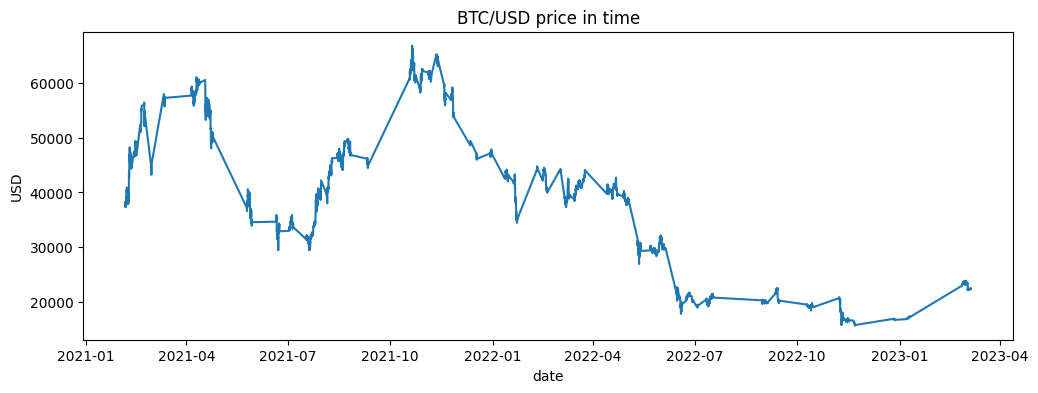

In [147]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['close'])

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')

# Displaying the plot
plt.show()

### Create Training and Test Set

## Task 1 -- Trend Prediction
For this task we consider the trend to be an uptrend (y = 1) if close[t] < open[t+1] and downtrend (y = 0) if close[t] >= open[t+1].

In [148]:
def generate_trend_prediction_set(dataset):

    data = dataset.copy(deep=True)
    l = data.shape[0]
    data['trend'] = [0]*l

    counter = 0
    counter_eq = 0 
    for index,row in data.iterrows():
        if index+1 >= l:
            continue
        if data.loc[index+1]['close'] > row['close']:
            if counter == 0:
                print("First uptrend :",row['date'])
            counter += 1
            data.at[index,'trend'] = 1
        elif data.loc[index+1]['close'] == row['close']:
            counter_eq +=1

    print("Uptrends counted:",counter)
    print("% of Uptrends:",(counter/l)*100)

    print("No trend counted:",counter_eq)
    print("% of no trends:",(counter_eq/l)*100)

    y = data['trend'].values
    data = data.drop(['trend','date'], axis = 1)

    return data.values,y

In [149]:
x, y = generate_trend_prediction_set(df)

First uptrend : 2021-02-05 10:00:00
Uptrends counted: 2075
% of Uptrends: 49.66491144088081
No trend counted: 12
% of no trends: 0.28721876495931065


### Normalization

In [150]:
scaler = RobustScaler()
x = scaler.fit_transform(x)

In [151]:
x2 = x[:, :-5] # remove sentiment

#### Hist Gradient Boosting Classifier

In [153]:
# Define different feature sets
feature_sets = [x, x2]  # Replace with your feature sets

# Create your HistGradientBoostingClassifier model
model = HistGradientBoostingClassifier(learning_rate=0.05, max_iter=2000, max_depth=15, min_samples_leaf=9, random_state=32)

# Define the F1 scorer for cross-validation
f1_scorer = make_scorer(f1_score, average='macro')

# Create a KFold splitter with the desired number of folds and random seed
kf = KFold(n_splits=5, shuffle=False)  # Adjust the number of splits as needed

# Iterate through different feature sets and evaluate them using the same cross-validation splits
for i, X_feature_set in enumerate(feature_sets):
    scores = cross_val_score(model, X_feature_set, y, cv=kf, scoring=f1_scorer)
    average_f1_score = scores.mean()
    print(f"Feature Set {i+1} - Average F1 Score:", average_f1_score)

Feature Set 1 - Average F1 Score: 0.5332174112569635
Feature Set 2 - Average F1 Score: 0.5090220198075219


### MLP

In [154]:
def create_mlp(input_len):
    model = Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape = (input_len,)))
    #model.add(layers.Dropout(0.25))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    #model.add(layers.Dropout(0.25))
    model.add(layers.Dense(2, activation='softmax'))
    return model

In [155]:
encoder = LabelEncoder()
y_train_dnn = encoder.fit_transform(y)

In [163]:
def mlp_cv(x, setNo):
    fold = 0
    num_folds = 5
    f1 = 0

    for train_indices, val_indices in kf.split(x):
        fold += 1
        print(f"Fold {fold}/{num_folds}")

        X_train, X_val = x[train_indices], x[val_indices]
        y_train, y_val = y_train_dnn[train_indices], y_train_dnn[val_indices]

        # Create and compile your TensorFlow model
        model = create_mlp(X_train.shape[1])  

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True)
        model.compile(optimizer='Nadam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

        # Train the model
        history = model.fit(X_train, y_train, epochs=500, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint], verbose=0)

        model.load_weights('best_weights.h5')
        y_pred = model.predict(X_val)

        y_pred_vals = list()

        for y in y_pred:
            if y[0] >= y[1]:
                y_pred_vals.append(0)
            else:
                y_pred_vals.append(1)
        
        f1 += f1_score(y_val,y_pred_vals, average = 'macro')


    print(f"Feature Set {setNo} - Average F1 Score:", (f1/5))

In [164]:
mlp_cv(x,1)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Feature Set 1 - Average F1 Score: 0.5305055528970373


In [165]:
mlp_cv(x2,2)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Feature Set 2 - Average F1 Score: 0.5239893936582947
